### Imports

In [21]:
# !pip install quandl
import quandl, math, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression

### Gather data

In [22]:
quandl.ApiConfig.api_key = 'yg1dWeMCUYWKqdJG6izS'
df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
# print(df.head())

### Transform data by dropping na first

In [23]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.01 * len(df)))  # predicting fwd looking 1% of the dataset
df['label'] = df[forecast_col].shift(-forecast_out)  # create col of DV that is shifted back by forecast_out amts

df.dropna(inplace=True)
# print(df.head())

### Create model and fit by dropping na first

In [24]:
X = np.array(df.drop(['label'], 1))  # drop label column, use everything else for features
y = np.array(df['label'])

X = preprocessing.scale(X)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

clf = LinearRegression()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

print(accuracy)

0.9770268261056929


### Transform data by keeping na values to use for predict

In [25]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.01 * len(df)))  # predicting fwd looking 1% of the dataset
df['label'] = df[forecast_col].shift(-forecast_out)  # create col of DV that is shifted back by forecast_out amts

### Create model and fit by keeping na values

In [27]:
X = np.array(df.drop(['label'], 1))  # drop label column, use everything else for features
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]  # use the no data rows for prediction
X = X[:-forecast_out]  # keep X up til rows with no data

df.dropna(inplace=True)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

clf = LinearRegression()
clf.fit(X_train, y_train)

# pickle to save classifier if needed
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

# check accuracy on test set and predict forecast set
accuracy = clf.score(X_test, y_test)
# print(accuracy)
forecast_set = clf.predict(X_lately)
# print(forecast_set, accuracy, forecast_out)

### Plot predictions for forecast set

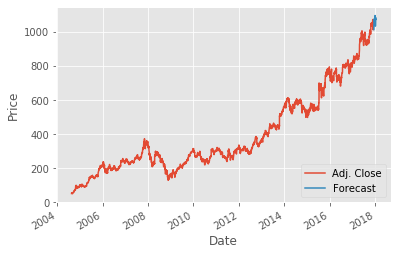

In [29]:
df['Forecast'] = np.nan  # column is non-number data

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400  # seconds in a day
next_unix = last_unix + one_day

# want to fill in the forecast set columns. use NA for close, HL_PCT etc, and add the forecast predicted data
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]  # the row index of next_date, set the columns for that row  
    
plt.style.use('ggplot')    
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()